# Long-range CNOT with parallel bell pairs
*Usage estimate: 4 minutes on a Heron r2 processor (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

Long-range entanglement between distant qubits is challenging on devices with limited connectivity. This tutorial shows how dynamic circuits can generate such entanglement by implementing a long-range controlled-X (LRCX) gate using a measurement-based protocol.  

Following the approach by Elisa Bäumer et al. in [1](#ref-1), the method uses mid-circuit measurement and feedforward to achieve constant-depth gates regardless of qubit separation. It creates intermediate Bell pairs, measures one qubit from each pair, and applies classically conditioned gates to propagate entanglement across the device. This avoids long SWAP chains, reducing both circuit depth and exposure to two-qubit gate errors.  

In this notebook, we adapt the protocol for IBM Quantum hardware and extend it to run multiple LRCX operations in parallel, allowing us to explore how performance scales with the number of simultaneous conditional operations.  


## Requirements

Before starting this tutorial, ensure that you have the following installed:

- Qiskit SDK 2.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime ( `pip install qiskit-ibm-runtime` ) 0.37 or later

## Setup

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate, Measure
from qiskit.circuit.classical import expr
from qiskit.primitives import BitArray
from qiskit.quantum_info import hellinger_fidelity
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_circuit_layout
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler
import matplotlib.pyplot as plt
import numpy as np
import random

## Step 1: Map classical inputs to a quantum problem

We now implement a long-range CNOT gate between two distant qubits, following the dynamic-circuit construction shown below (adapted from Fig. 1a in Ref. [1](#ref-1)). The key idea is to use a “bus” of ancilla qubits, initialized to $|0\rangle$, to mediate long-range gate teleportation.  

![Long-range CNOT circuit](/docs/images/tutorials/long-range-entanglement-with-limited-qubit-connectivity/dynamic_vs_unitary_long_range_illustration.avif)

As illustrated in the figure, the process works as follows:  
1. Prepare a chain of Bell pairs connecting the control and target qubits via intermediate ancillas.  
2. Perform Bell measurements between non-entangled neighboring qubits, swapping entanglement step-by-step until the control and target share a Bell pair.  
3. Use this Bell pair for gate teleportation, turning a local CNOT into a deterministic long-range CNOT in constant depth.  

This approach replaces long SWAP chains with a constant-depth protocol, reducing exposure to two-qubit gate errors and making the operation scalable with device size.  

In what follows, we will first walk through the dynamic-circuit implementation of the LRCX circuit. At the end, we will also provide a unitary-based implementation for comparison, to highlight the advantages of dynamic circuits in this setting. 

### (i) Initialize circuit  

We begin with a simple quantum problem that will serve as the basis for comparison. Specifically, we initialize a circuit with a control qubit at index 0 and apply a Hadamard gate to it. This produces a superposition state that, when followed by a controlled-X operation, generates a Bell state  $(|00\rangle + |11\rangle)/\sqrt{2}$ between the control and target qubits.  

At this stage, we are not yet constructing the long-range controlled-X (LRCX) itself. Instead, our goal is to define a clear and minimal initial circuit that highlights the role of the LRCX. In Step 2, we will show how the LRCX can be implemented as an optimization using dynamic circuits, and compare its performance against a unitary equivalent. Importantly, the LRCX protocol can be applied to any initial circuit. Here we use this simple Hadamard setup for clarity of demonstration.  


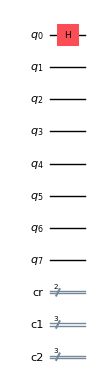

In [2]:
distance = 6 # The distance of the CNOT gate, with the convention that a distance of zero is a nearest-neighbor CNOT.

def initialize_circuit(distance):
    assert(distance >= 0)
    control = 0 # control qubit
    n = distance # number of qubits between target and control

    qr = QuantumRegister(n + 2, name="q")  # Circuit with n qubits between control and target
    cr = ClassicalRegister(2, name="cr")  # Classical register for measuring control and target qubits

    k = int(n / 2)  # Number of Bell States to be used
    
    allcr = [cr]
    if distance > 1: # This classical register will be used to store ZZ measurements. It is only used for long-range CX gates with distance > 1
        c1 = ClassicalRegister(k, name="c1")  # Classical register needed for post processing
        allcr.append(c1)
    if distance > 0: # This classical register will be used to store XX measurements. It is only used if distance > 0
        c2 = ClassicalRegister(n - k, name="c2")  # Classical register needed for post processing
        allcr.append(c2)

    qc = QuantumCircuit(qr, *allcr, name="CNOT")

    # Apply a Hadamard gate to the control qubit such that the long-range CNOT gate will prepare a Bell state (|00> + |11>)/sqrt(2)
    qc.h(control)
    
    return qc

qc = initialize_circuit(distance)
qc.draw(fold=-1, output='mpl', scale=0.5)

## Step 2: Optimize problem for quantum hardware execution
In this step, we show how to construct the LCRX circuit using dynamic circuits. The goal is to optimize the circuit for execution on hardware by reducing depth compared to a purely unitary implementation. To illustrate the benefits, we will display both the dynamic LRCX construction and its unitary equivalent, and later compare their performance after transpilation. Importantly, while here we apply the LRCX to a simple Hadamard-initialized problem, the protocol can be applied to any circuit where a long-range CNOT is required.  

### (ii) Prepare Bell pairs  
We begin by creating a chain of Bell pairs along the path between the control and target qubits. If the distance is odd, we first apply a CNOT from the control to its neighbor, which is the CNOT that will be teleported. For an even distance, this CNOT will be applied after the Bell pair preparation step. The Bell pair chain then entangles successive pairs of qubits, establishing the resource needed to carry the control information across the device.  


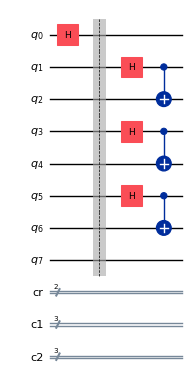

In [3]:
# Determine where to start the Bell pair chain and add an extra CNOT when n is odd
check_even = lambda n: 1 if n % 2 == 0 else 2 #return 1 if even, 2 if odd

def prepare_bell_pairs(qc, add_barriers=True):
    n = qc.num_qubits - 2 # number of qubits between target and control
    k = int(n / 2) 
    
    if add_barriers:
        qc.barrier()
        
    x0 = check_even(n)
    if n % 2 != 0:
        qc.cx(0, 1)
    
    # Create k Bell pairs
    for i in range(k):
        qc.h(x0 + 2 * i)
        qc.cx(x0 + 2 * i, x0 + 2 * i + 1)
    return qc

qc = prepare_bell_pairs(qc)
qc.draw(output='mpl', fold=-1, scale=0.5)

### (iii) Measure neighboring qubit pairs in the Bell basis
Next, we measure *unentangled* neighboring qubits in the Bell basis (i.e., two-qubit measurements of $XX$ and $ZZ$). This creates a long-range Bell pair between the target qubit, and the qubit adjacent to the control (up to Pauli corrections, which will be implemented via feedforward in the next step). In parallel, we implement the entangling measurement that teleports the CNOT gate to act on the intended target qubit.

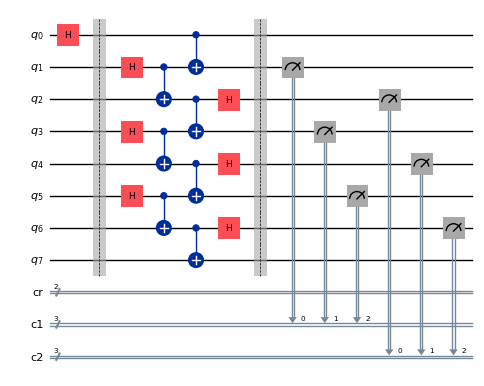

In [4]:
def measure_bell_basis(qc, add_barriers=True):
    n = qc.num_qubits - 2 # number of qubits between target and control
    k = int(n / 2) 
    
    if n > 1:
        _, c1, c2 = qc.cregs
    elif n > 0:
        _, c2 = qc.cregs
    
    # Determine where to start the Bell pair chain and add an extra CNOT when n is odd
    x0 = 1 if n % 2 == 0 else 2
    
    # Entangling layer that implements the Bell measurement (and additionally adds the CNOT to be teleported, if n is even)
    for i in range(k + 1):
        qc.cx(x0 - 1 + 2 * i, x0 + 2 * i)
        
    for i in range(1, k + x0):
        if i == 1:
            qc.h(2 * i + 1 - x0)
        else:
            qc.h(2 * i + 1 - x0)

    if add_barriers:
        qc.barrier()

    # Map the ZZ measurements onto classical register c1
    for i in range(k):
        if i == 0:
            qc.measure(2 * i + x0, c1[i])
        else:
            qc.measure(2 * i + x0, c1[i])

    # Map the XX measurements onto classical register c2
    for i in range(1, k + x0):
        if i == 1:
            qc.measure(2 * i + 1 - x0, c2[i - 1])
        else:
            qc.measure(2 * i + 1 - x0, c2[i - 1])
    return qc

qc = measure_bell_basis(qc)
qc.draw(output='mpl', fold=-1, scale=0.5)

### (iv) Next, apply feedforward corrections to correct Pauli byproduct operators

The Bell-basis measurements introduce Pauli byproducts that must be corrected using the recorded outcomes. This is done in two steps. First, we need to compute the parity of all $ZZ$ measurements, which is then used to conditionally apply an $X$ gate to the target qubit. Likewise, the parity of the $XX$ measurements is computed and used to conditionally apply a $Z$ gate to the control qubit.
 
With the new classical expression framework in Qiskit, these parities can be computed directly in the classical processing layer of the circuit. Instead of applying a sequence of individual conditional gates for each measurement bit, we can build a single classical expression that represents the XOR (parity) of all relevant measurement outcomes. This expression is then used as the condition in a single `if_test` block, allowing the correction gates to be applied in constant depth. This approach both simplifies the circuit and ensures that the feedforward corrections do not introduce unnecessary additional latency.


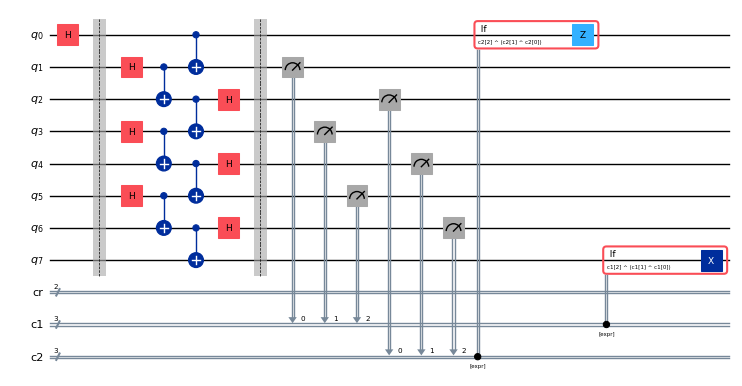

In [5]:
def apply_ffwd_corrections(qc):
    control = 0 # control qubit
    target = qc.num_qubits - 1 # target qubit
    n = qc.num_qubits - 2 # number of qubits between target and control
    
    k = int(n / 2) 
    x0 = check_even(n)
    
    if n > 1:
        _, c1, c2 = qc.cregs
    elif n > 0:
        _, c2 = qc.cregs
    
    # First, let's compute the parity of all ZZ measurements
    for i in range(k):
        if i == 0:
            parity_ZZ = expr.lift(c1[i]) # Store the value of the first ZZ measurement in parity_ZZ
        else:
            parity_ZZ = expr.bit_xor(c1[i], parity_ZZ) # Successively compute the parity via XOR operations
            
    for i in range(1, k + x0):
        if i == 1:
            parity_XX = expr.lift(c2[i - 1]) # Store the value of the first XX measurement in parity_XX
        else:
            parity_XX = expr.bit_xor(c2[i - 1], parity_XX) # Successively compute the parity via XOR operations

    if n > 0:
        with qc.if_test(parity_XX):
            qc.z(control)

    if n > 1:
        with qc.if_test(parity_ZZ):
            qc.x(target)
    return qc


qc = apply_ffwd_corrections(qc)
qc.draw(output='mpl', fold=-1, scale=0.5)

### (v) Finally, measure control and target qubits
We define a helper function that enables measurement of the control and target qubits in the $XX$, $YY$, or $ZZ$ bases. For verifying the Bell state $(|00\rangle + |11\rangle)/\sqrt{2}$, the expectation values of $XX$ and $ZZ$ should both be $+1$, since they are stabilizers of the state. The $YY$ measurement is also supported here and will be used below when computing the fidelity.


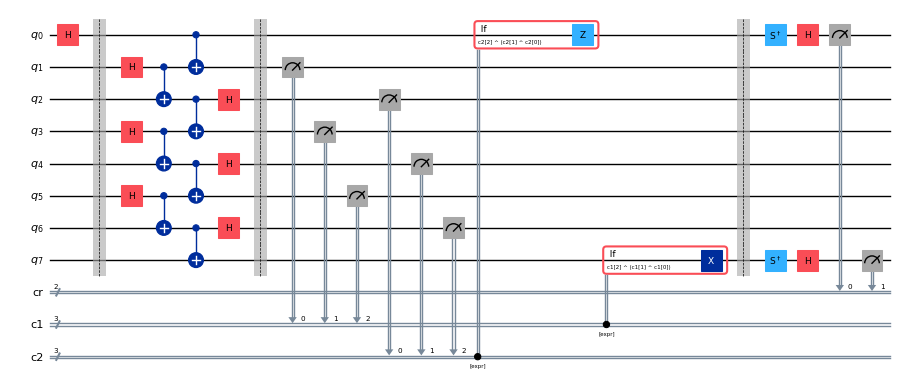

In [6]:
def measure_in_basis(qc, basis = 'XX', add_barrier=True):
    control = 0 # control qubit
    target = qc.num_qubits - 1 # target qubit

    assert(basis in ['XX', 'YY', 'ZZ'])
    
    qc = qc.copy() #we copy the circuit because we want to measure in different bases
    cr = qc.cregs[0]
    
    if add_barrier:
        qc.barrier()
    
    if basis == 'XX':
        qc.h(control)
        qc.h(target)
    elif basis == 'YY':
        qc.sdg(control)
        qc.sdg(target)
        qc.h(control)
        qc.h(target)
    
    qc.measure(control, cr[0])
    qc.measure(target, cr[1])
    return qc

qc_YY = measure_in_basis(qc.copy(), basis='YY')
display(qc_YY.draw(output='mpl', fold=-1, scale=0.5)) # Circuit for measuring in the YY basis

### Putting it all together
We combine the various steps defined above to create a long-range CX gate on two ends of an 1D line. The steps include
- Initializing the control qubit in $\ket{+}$
- Preparing Bell pairs
- Measuring neighboring qubit pairs
- Applying feedforward corrections dependent on the MCMs

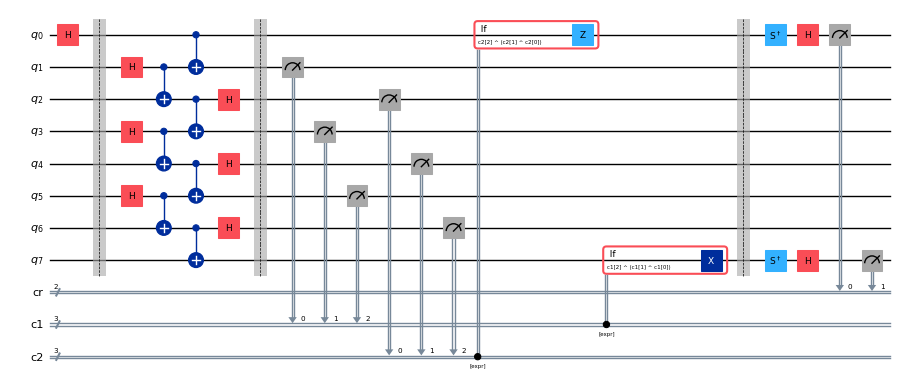

In [7]:
def lrcx(distance, prep_barrier=True, pre_measure_barrier=True):
    qc = initialize_circuit(distance)
    qc = prepare_bell_pairs(qc,prep_barrier)
    qc = measure_bell_basis(qc,pre_measure_barrier)
    qc = apply_ffwd_corrections(qc)
    return qc

qc = lrcx(distance)
# Apply the measurement in the XX, YY, and ZZ bases
qc_XX, qc_YY, qc_ZZ= [measure_in_basis(qc, basis=basis) for basis in ['XX', 'YY', 'ZZ']]

display(qc_YY.draw(output='mpl', fold=-1, scale=0.5)) # Circuit for measuring in the YY basis

### Generating circuits for different distances

We now generate long-range CX circuits for a range of qubit separations. For each distance, we build circuits that measure in the $XX$, $YY$, and $ZZ$ bases, which will later be used to compute fidelities.  

The list of distances includes both short- and long-range separations, with `distance = 0` corresponding to a nearest-neighbor CX. These same distances will also be used to generate the corresponding unitary circuits later for comparison.

Number of circuits: 39


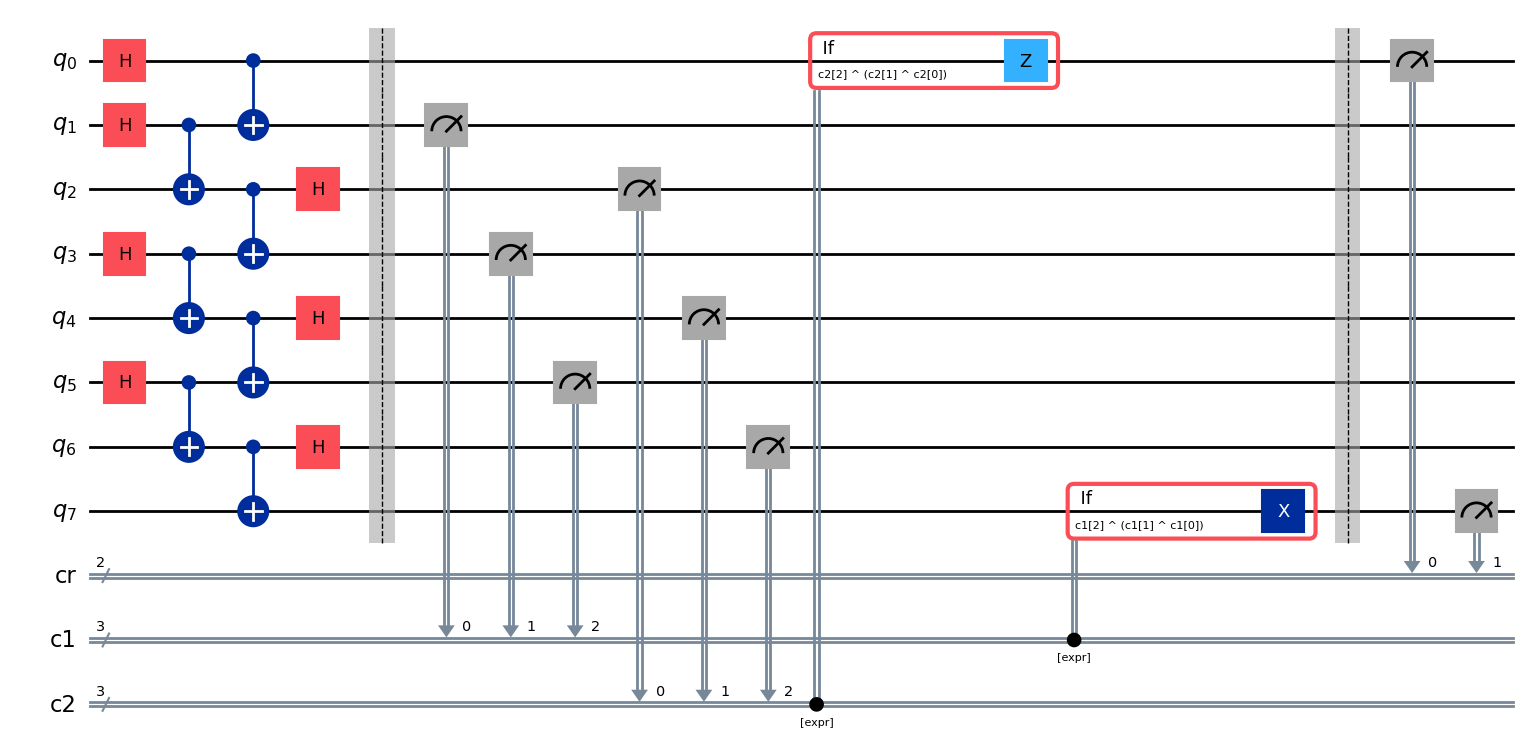

In [8]:
distances = [0, 1, 2, 3, 6, 11, 16, 21, 28, 35, 44, 55, 60] # distances for long range CX. distance of 0 is a nearest-neighbor CX
distances.sort() 
assert min(distances)>=0 # only works for distance larger than 2 because classical register cannot be empty 
basis_list = ['XX', 'YY', 'ZZ']

circuits_dyn = []
for distance in distances:
    for basis in basis_list:
        circuits_dyn.append(measure_in_basis(lrcx(distance, prep_barrier=False),basis=basis))
print(f"Number of circuits: {len(circuits_dyn)}")
circuits_dyn[14].draw(fold=-1, output='mpl', idle_wires=False)

#### Unitary-based implementation swapping the qubits to the middle

For comparison, we first examine the case where a long-range CNOT gate is implemented using nearest-neighbor connections and unitary gates. In the following figure, on the left is a circuit for a long-range CNOT gate spanning a 1D chain of n-qubits subject to nearest-neighbor connections only. On the middle is an equivalent unitary decomposition implementable with local CNOT gates, circuit depth $O(n)$.

![Long-range CNOT circuit](/docs/images/tutorials/long-range-entanglement-with-limited-qubit-connectivity/dynamic_vs_unitary_long_range_illustration.avif)

The circuit on the middle can be implemented as follows:

In [9]:
def cnot_unitary(distance):
    """ Generate a long range CNOT gate using local CNOTs on a 1D chain of qubits subject to n
    earest-neighbor connections only.
    

    Args: 
        distance (int) : The distance of the CNOT gate, with the convention that a distance of 0 is a nearest-neighbor CNOT.

    Returns:
        QuantumCircuit: A Quantum Circuit implementing a long-range CNOT gate between qubit 0 and qubit distance+1
    """
    assert(distance >= 0)
    n = distance # number of qubits between target and control

    qr = QuantumRegister(n + 2, name="q")  # Circuit with n qubits between control and target
    cr = ClassicalRegister(2, name="cr")  # Classical register for measuring control and target qubits

    qc = QuantumCircuit(qr, cr, name="CNOT_unitary")

    control_qubit = 0

    qc.h(control_qubit) # Prepare the control qubit in the |+> state

    k = int(n / 2)
    qc.barrier()
    for i in range(control_qubit, control_qubit + k):
        qc.cx(i, i + 1)
        qc.cx(i + 1, i)
        qc.cx(-i - 1, -i - 2)
        qc.cx(-i - 2, -i - 1)
    if n % 2 == 1:
        qc.cx(k + 2, k + 1)
        qc.cx(k + 1, k + 2)
    qc.barrier()
    qc.cx(k, k + 1)
    for i in range(control_qubit, control_qubit + k):
        qc.cx(k - i, k - 1 - i)
        qc.cx(k - 1 - i, k - i)
        qc.cx(k + i + 1, k + i + 2)
        qc.cx(k + i + 2, k + i + 1)
    if n % 2 == 1:
        qc.cx(-2, -1)
        qc.cx(-1, -2)
    
    return qc


Now build all unitary circuits, and build the circuits that measure in the $XX$, $YY$, and $ZZ$ bases, just like we did for the dynamic circuits above.

Number of circuits: 39


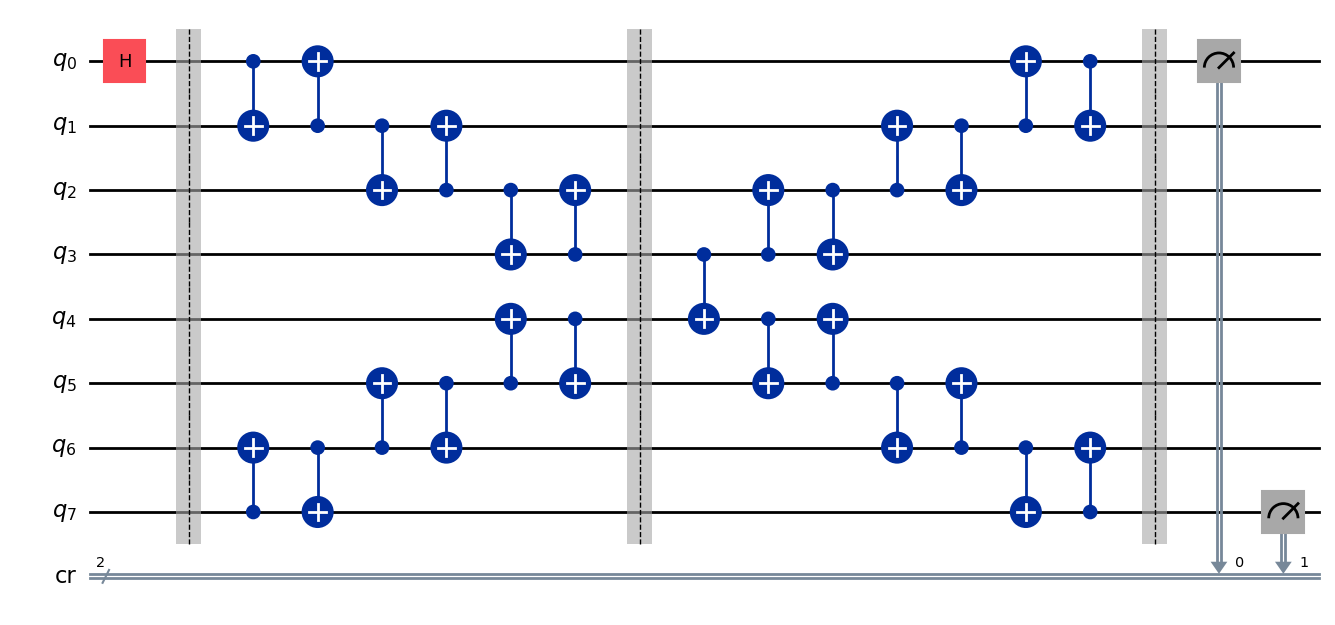

In [10]:
circuits_uni = []
for distance in distances:
    for basis in basis_list:
        circuits_uni.append(measure_in_basis(cnot_unitary(distance),basis=basis))

print(f"Number of circuits: {len(circuits_uni)}")
circuits_uni[14].draw(fold=-1, output='mpl', idle_wires=False)

Now we have both dynamic and unitary circuits for a range of distances, we ready for transpilation. We first need to select a backend device.

In [11]:
# Set up access to IBM Quantum devices 
from qiskit.circuit import IfElseOp

service = QiskitRuntimeService() 
backend_name='ibm_kingston' 
backend=service.backend(backend_name)

qiskit_runtime_service._get_crn_from_instance_name:WARNING:2025-09-12 16:48:10,456: Multiple instances found. Using all matching instances.


The following step ensures that the backend supports the `if_else` instruction, which is required for the newer version of dynamic circuits. Since this feature is still in early access, we explicitly add the `IfElseOp` to the backend target if it is not already available.

In [12]:
if "if_else" not in backend.target.operation_names:
    backend.target.add_instruction(IfElseOp, name="if_else")

#### Use Layer Fidelity string for selecting 1D chain 
Since we want to compare the performance of dynamic and unitary circuits on a 1D chain, we use the Layer Fidelity string to select a linear topology of the best chain of qubits from the device. This ensures that both types of circuits are transpiled under the same connectivity constraints, allowing for a fair comparison of their performance.

In [13]:
# This selects best qubits for longest distance and uses the same control for all lengths
lf_qubits = backend.properties().to_dict()['general_qlists'] # best linear chain qubits
chosen_layouts = {distance: [val['qubits'] for val in lf_qubits if val['name'] == f'lf_{distances[-1] + 2}'][0][: distance + 2] 
                    for distance in distances}
print(chosen_layouts[max(distances)]) # best qubits at each distance

[10, 11, 12, 13, 14, 15, 19, 35, 34, 33, 39, 53, 54, 55, 59, 75, 74, 73, 72, 71, 58, 51, 50, 49, 48, 47, 46, 45, 44, 43, 56, 63, 62, 61, 76, 81, 82, 83, 84, 85, 77, 65, 66, 67, 68, 69, 78, 89, 90, 91, 98, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101]


In [14]:
isa_circuits_dyn = []
isa_circuits_uni = []

# Using the same initial layouts for both circuits for better apples to apples comparison
for qc in circuits_dyn:
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend, initial_layout=chosen_layouts[qc.num_qubits - 2])
    isa_circuits_dyn.append(pm.run(qc))

for qc in circuits_uni:
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend, initial_layout=chosen_layouts[qc.num_qubits - 2])
    isa_circuits_uni.append(pm.run(qc))

2Q depth: 2


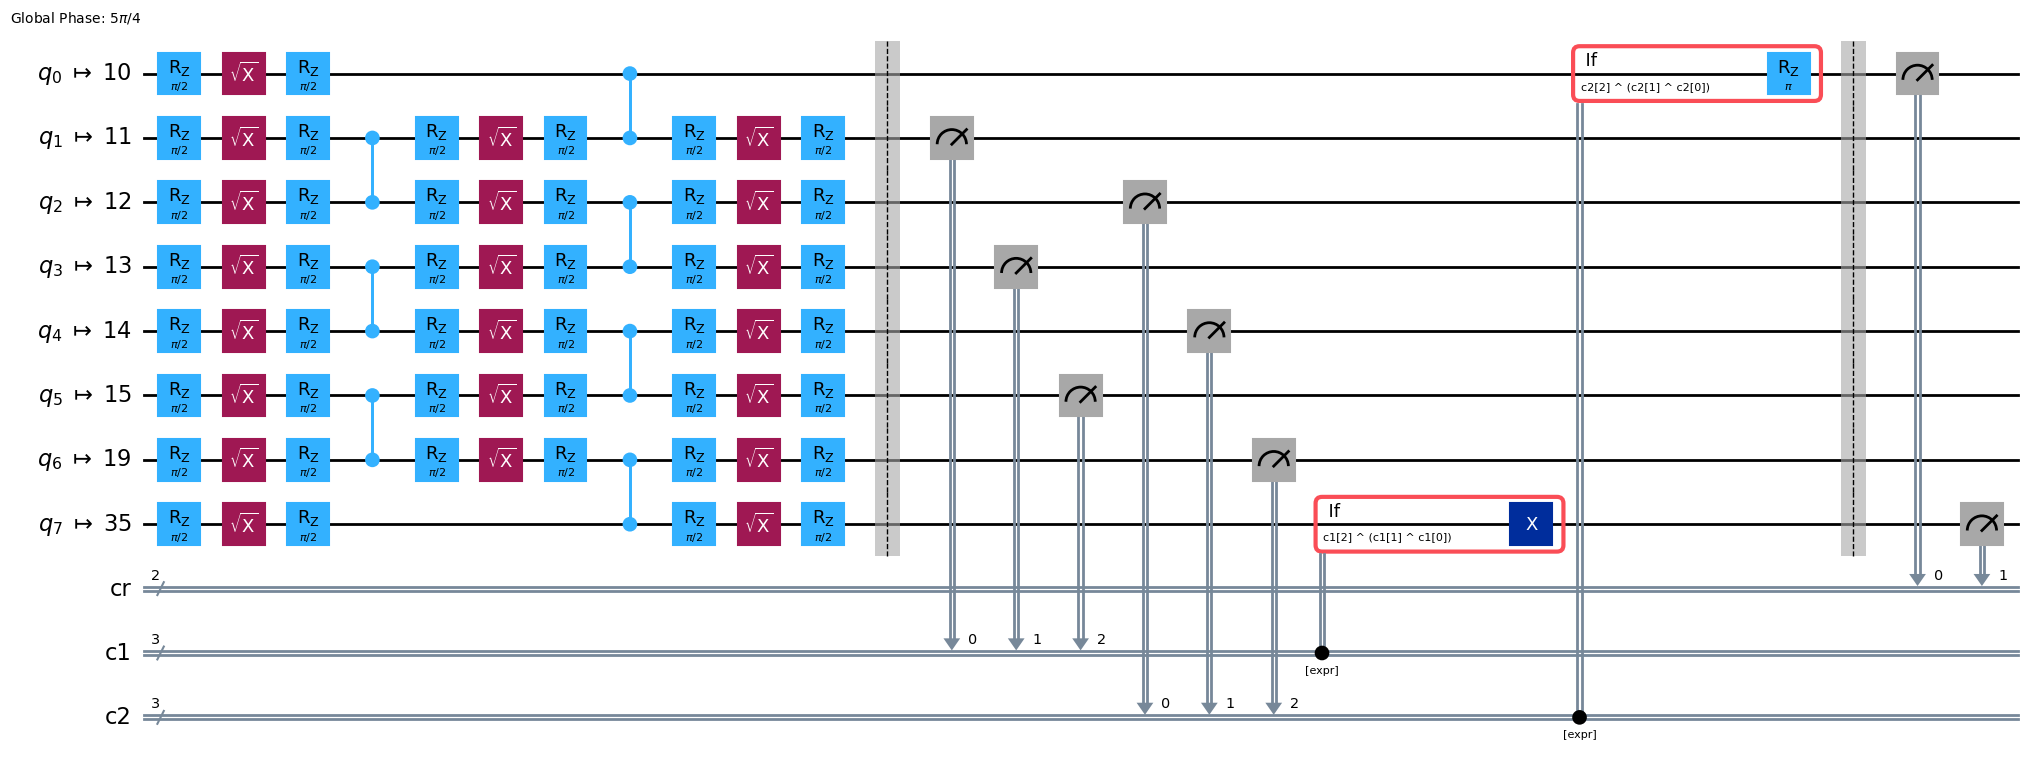

In [15]:
print(f"2Q depth: {isa_circuits_dyn[14].depth(lambda x: x.operation.num_qubits == 2)}")
isa_circuits_dyn[14].draw('mpl',fold=-1,idle_wires=0)

2Q depth: 13


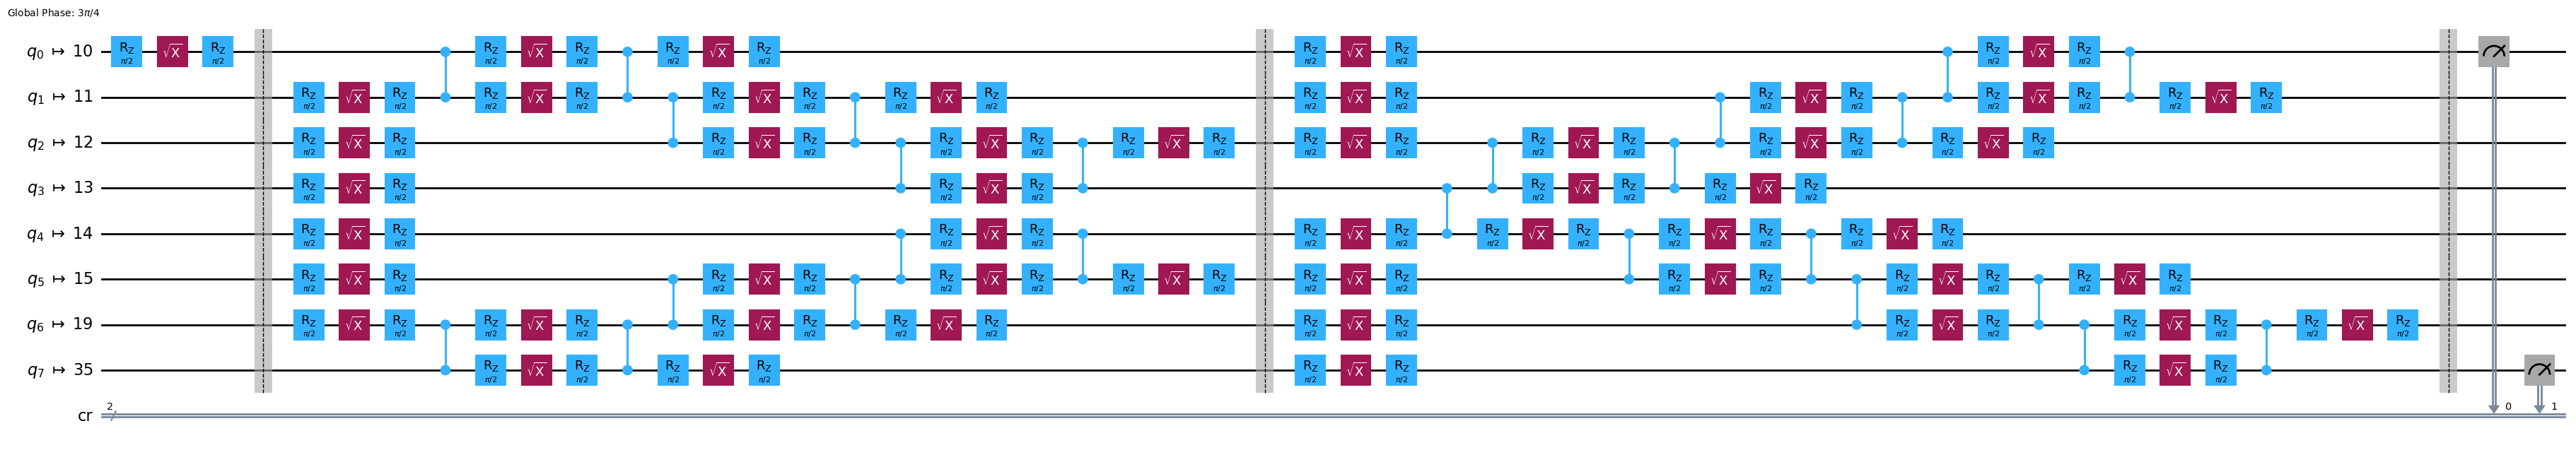

In [16]:
print(f"2Q depth: {isa_circuits_uni[14].depth(lambda x: x.operation.num_qubits == 2)}")
isa_circuits_uni[14].draw('mpl',fold=-1,idle_wires=False)

### Visualize qubits used for the LRCX circuit

In this section, we examine how the LRCX circuit is mapped onto hardware. We start by visualizing the physical qubits used in the circuit and then study how the control–target distance in the layout impacts the number of operations.


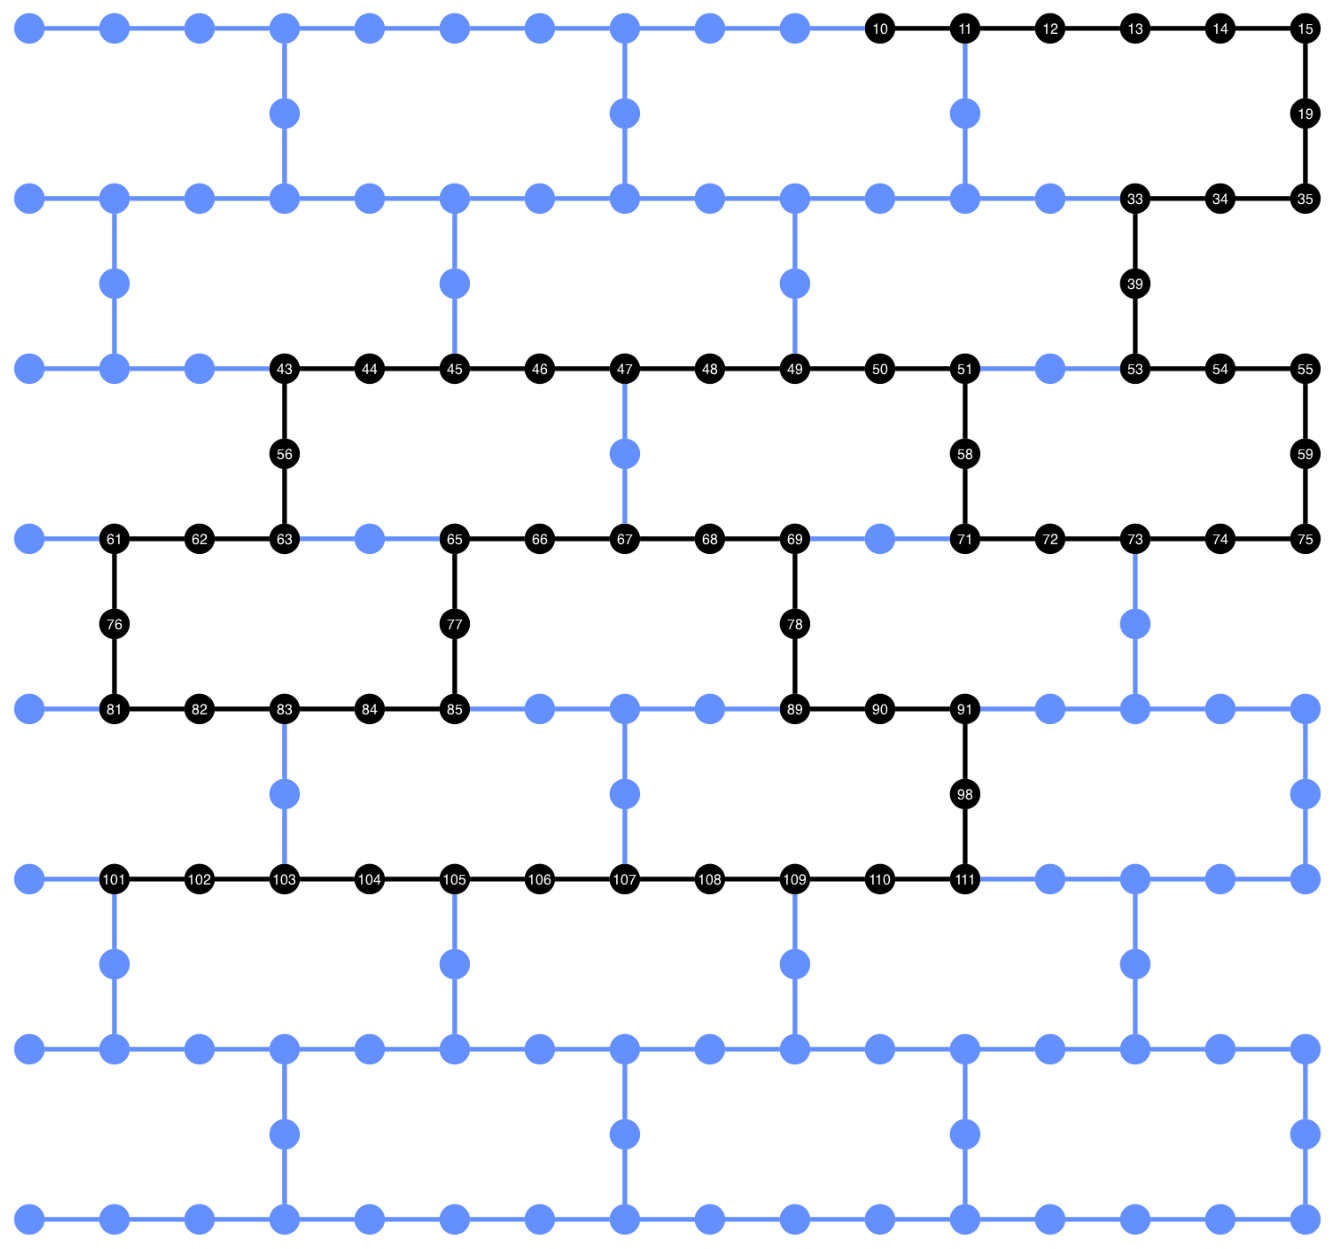

In [17]:
# Note: the qubit coordinates must be hard-coded.
# The backend API does not currently provide this information directly.
# If using a different backend, you will need to adjust the coordinates accordingly,
# or set the qubit_coordinates = None to use the default layout coordinates.

def _heron_coords_r2():
    """ Generate coordinates for the Heron layout in R2. Note """
    cord_map = np.array([
        [
            0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
                  3,      7,       11,         15,
            0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
              1,      5,      9,         13,
            0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
                  3,      7,       11,         15,
            0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
              1,      5,      9,         13,
            0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
                  3,      7,       11,         15,
            0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
              1,      5,      9,         13,
            0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
                  3,      7,       11,         15,
            0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,
        ],
        -1*np.array(
            [j for i in range(15) for j in [i]*[16,4][i%2]]
        )
    ], dtype=int)

    hcords = []
    ycords = cord_map[0]
    xcords = cord_map[1]
    for i in range(156):
        hcords.append([xcords[i]+1, np.abs(ycords[i])+1])

    return hcords

# Visualize the active qubits in the circuit layout
plot_circuit_layout(circuit=isa_circuits_uni[-1], backend=backend, view="physical", qubit_coordinates=_heron_coords_r2())

## Step 3: Execute using Qiskit primitives  

In this step, we execute the experiment on the specified backend. To access the latest dynamic circuit capabilities, the `gen3-experimental` execution path must be specified. We also make use of batching to efficiently run the experiment across multiple trials. Running repeated trials allows us to compute averages for a more accurate comparison between the unitary and dynamic methods, as well as to quantify their variability by comparing the deviations across runs.  


In [18]:
print(backend.name)

ibm_kingston


Select number of trials and perform batch execution.

In [19]:
num_trials = 10
jobs_uni = []
jobs_dyn = []
with Batch(backend=backend) as batch:
    sampler = Sampler(mode=batch)
    sampler.options.experimental= {
    "execution_path" : "gen3-experimental"
    }
    for _ in range(num_trials):
        jobs_uni.append(sampler.run(isa_circuits_uni, shots=1024))
        jobs_dyn.append(sampler.run(isa_circuits_dyn, shots=1024))

## Step 4: Post-process and return result in desired classical format
After the experiments have successfully executed, we now post-process the measurement counts to extract meaningful metrics.  
In this step, we:  

- Define quality metrics for evaluating the performance of the long-range CX.  
- Compute expectation values of Pauli operators from raw measurement outcomes.  
- Use these to calculate the fidelity of the generated Bell state.  

This analysis provides a clear picture of how well the dynamic circuits perform relative to the unitary baseline implementation.  

### Quality Metric  

To evaluate the success of the long-range CX protocol, we measure how close the output state is to the ideal Bell state. A convenient way to quantify this is by computing the state fidelity using expectation values of Pauli operators. Fidelity for a Bell state on the control and target state can be computed after knowing the $\braket{XX}$, $\braket{YY}$, and $\braket{ZZ}$. In particular,

$$ F = \frac{1}{4} (1 + \braket{XX} - \braket{YY} + \braket{ZZ})$$

To compute these expectation values from raw measurement data, we define a set of helper functions:  

- **`compute_ZZ_expectation`**: Given measurement counts, computes the expectation value of a two-qubit Pauli operator in the $Z$ basis.  
- **`compute_fidelity`**: Combines the expectation values of $XX$, $YY$, and $ZZ$ into the fidelity expression above.  
- **`get_counts_from_bitarray`**: Utility to extract counts from backend result objects.  

In [20]:
def compute_ZZ_expectation(counts):
    total = sum(counts.values())
    expectation = 0
    for bitstring, count in counts.items():
        # Ensure bitstring is 2 bits
        z1 = (-1)**(int(bitstring[-1])) 
        z2 = (-1)**(int(bitstring[-2])) 
        expectation += z1 * z2 * count
    return expectation / total

def compute_fidelity(counts_xx, counts_yy, counts_zz):
    xx, yy, zz = [compute_ZZ_expectation(c) for c in [counts_xx, counts_yy, counts_zz]]
    return 1/4 * (1 + xx - yy + zz)

We compute the fidelity for the dynamic long-range CX circuits.  For each distance, we extract measurement outcomes in the $\braket{XX}$, $\braket{YY}$, and $\braket{ZZ}$ bases. These results are combined using the previously defined helper functions to calculate the fidelity according to  $F = \tfrac{1}{4} \big( 1 + \langle XX \rangle - \langle YY \rangle + \langle ZZ \rangle \big)$. This provides the observed fidelity of the dynamically executed protocol at each distance.  


In [21]:
fidelities_dyn = []

# loop over trials
for job in jobs_dyn:
    result_dyn = job.result()
    trial_fidelities = []
    # loop over all distances
    for ind, dist in enumerate(distances):
        counts_xx = result_dyn[ind*3].data.cr.get_counts()
        counts_yy = result_dyn[ind*3+1].data.cr.get_counts()
        counts_zz = result_dyn[ind*3+2].data.cr.get_counts()
        trial_fidelities.append(compute_fidelity(counts_xx, counts_yy, counts_zz))
    fidelities_dyn.append(trial_fidelities)
# average over trials for each distance
avg_fidelities_dyn = np.mean(fidelities_dyn, axis=0)
std_fidelities_dyn = np.std(fidelities_dyn, axis=0)


Now we compute the fidelity for the unitary long-range CX circuits, and we do it the same way as we did for the dynamic circuits above.

In [22]:
fidelities_uni = []

# loop over trials
for job in jobs_uni:
    result_uni = job.result()
    trial_fidelities = []
    # loop over all distances
    for ind, dist in enumerate(distances):
        counts_xx = result_uni[ind*3].data.cr.get_counts()
        counts_yy = result_uni[ind*3+1].data.cr.get_counts()
        counts_zz = result_uni[ind*3+2].data.cr.get_counts()
        trial_fidelities.append(compute_fidelity(counts_xx, counts_yy, counts_zz))
    fidelities_uni.append(trial_fidelities)
# average over trials for each distance
avg_fidelities_uni = np.mean(fidelities_uni, axis=0)
std_fidelities_uni = np.std(fidelities_uni, axis=0)

### Plot the results
To appreciate the results visually, the cell below plots the estimated gate fidelities measured at varying distance between entangled qubits for the methods. 

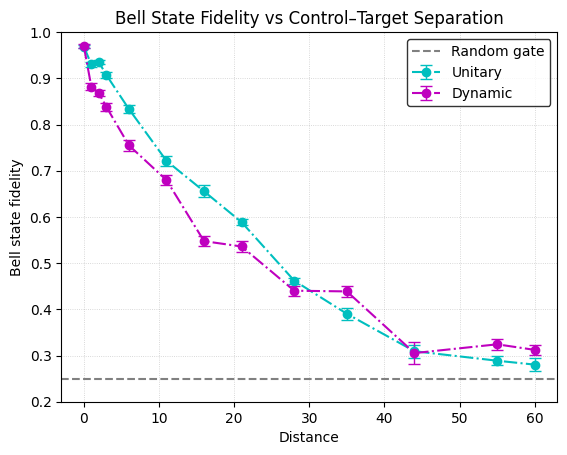

In [23]:
fig, ax = plt.subplots()

# Unitary with error bars
ax.errorbar(
    distances, avg_fidelities_uni, yerr=std_fidelities_uni,
    fmt="o-.", color="c", ecolor="c", elinewidth=1, capsize=4,
    label="Unitary"
)
# Dynamic with error bars
ax.errorbar(
    distances, avg_fidelities_dyn, yerr=std_fidelities_dyn,
    fmt="o-.", color="m", ecolor="m", elinewidth=1, capsize=4,
    label="Dynamic"
)
# Random gate baseline
ax.axhline(y=1/4, linestyle="--", color="gray", label="Random gate")

legend = ax.legend(frameon=True)
for text in legend.get_texts():
    text.set_color("black")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("black")
ax.set_title("Bell State Fidelity vs Control–Target Separation", color="black")
ax.set_xlabel("Distance", color="black")
ax.set_ylabel("Bell state fidelity", color="black")
ax.grid(linestyle=":", linewidth=0.6, alpha=0.4, color="gray")
ax.set_ylim((0.2, 1))
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")
plt.show()


From the fidelity plot above, the LRCX did not consistently outperform the direct unitary implementation. In fact, for short control–target separations, the unitary circuit achieved higher fidelity. However, at larger separations, the dynamic circuit begins to achieve better fidelity than the unitary implementation. This behavior is not unexpected on current hardware: while dynamic circuits reduce circuit depth by avoiding long SWAP chains, they introduce additional circuit time from mid-circuit measurements, classical feedforward, and control-path delays. The added latency increases decoherence and readout errors, which can outweigh the depth savings at short distances.

Nevertheless, we observe a crossover point where the dynamic approach surpasses the unitary one. This is a direct result of the different scaling: the depth of the unitary circuit grows linearly with the distance between qubits, while the depth of the dynamic circuit remains constant.

**Key points:**
- **Immediate benefit of DC:** The main present-day motivation is reduced *two-qubit depth*, not necessarily improved fidelity.
- **Why fidelity can be worse today:** Increased circuit time from measurement and classical operations often dominates, especially when the control–target separation is small.
- **Looking forward:** As hardware improves, specifically faster readout, shorter classical control latency, and reduced mid-circuit overhead, we should expect these depth and durations reductions to translate into measurable fidelity gains.

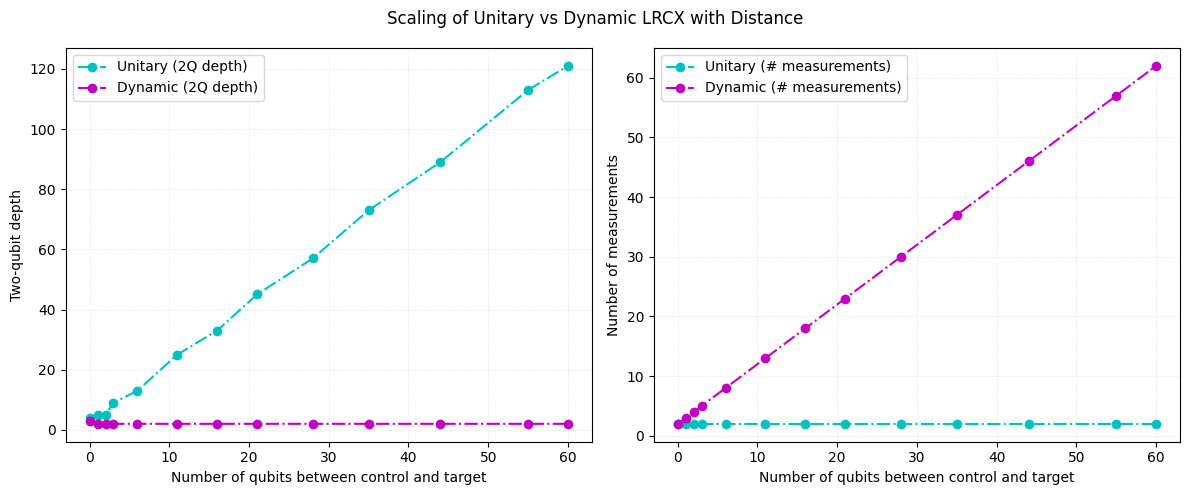

In [24]:
# Compute metrics for each distance, skipping the basis circuits since they are identical for each distance
depths_2q_dyn = [c.depth(lambda x: x.operation.num_qubits == 2) for c in isa_circuits_dyn[::3]]
meas_dyn      = [sum(1 for instr in c.data if instr.operation.name == "measure") for c in isa_circuits_dyn[::3]]

depths_2q_uni = [c.depth(lambda x: x.operation.num_qubits == 2) for c in isa_circuits_uni[::3]]
meas_uni      = [sum(1 for instr in c.data if instr.operation.name == "measure") for c in isa_circuits_uni[::3]]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(distances, depths_2q_uni, "o-.", color="c", label="Unitary (2Q depth)")
axes[0].plot(distances, depths_2q_dyn, "o-.", color="m", label="Dynamic (2Q depth)")
axes[0].set_xlabel("Number of qubits between control and target")
axes[0].set_ylabel("Two-qubit depth")
axes[0].grid(True, linestyle=":", linewidth=0.6, alpha=0.4)
axes[0].legend()

axes[1].plot(distances, meas_uni, "o-.", color="c", label="Unitary (# measurements)")
axes[1].plot(distances, meas_dyn, "o-.", color="m", label="Dynamic (# measurements)")
axes[1].set_xlabel("Number of qubits between control and target")
axes[1].set_ylabel("Number of measurements")
axes[1].grid(True, linestyle=":", linewidth=0.6, alpha=0.4)
axes[1].legend()

fig.suptitle("Scaling of Unitary vs Dynamic LRCX with Distance", fontsize=12)

plt.tight_layout()
plt.show()


This two-qubit depth plot highlights the primary advantage of the LRCX implemented with dynamic circuits: performance remains essentially constant as the separation between control and target qubits increases. In contrast, the unitary implementation grows linearly with distance due to the required SWAP chains. Depth captures the logical scaling of two-qubit operations, while the measurement count reflects the additional overhead for dynamic circuits. These measurements are efficient, since they are performed in parallel, but they still introduce a fixed cost on today’s hardware.

Why fidelity can be worse today: Increased circuit time from measurement and classical operations often dominates, especially when the control-target separation is small. For example, the average readout length on ibm_kingston is 2,280 ns, whereas its 2Q gate length is only 68 ns.

As measurement and classical latencies improve, we expect the constant-depth and constant-measurement scaling of dynamic circuits to yield clear fidelity and runtime advantages on larger circuits.

## References

<a id="ref-1"></a>
[1] Efficient Long-Range Entanglement using Dynamic Circuits, by
*Elisa Bäumer, Vinay Tripathi, Derek S. Wang, Patrick Rall, Edward H. Chen, Swarnadeep Majumder, Alireza Seif, Zlatko K. Minev*. IBM Quantum, (2023).
https://arxiv.org/abs/2308.13065